# Neural Network - benchmark comparison

This notebook was used for training a small Neural Network inspired by [Jagers (2003)](https://research.utwente.nl/en/publications/modelling-planform-changes-of-braided-rivers).

In [1]:
# move to root directory

%cd .. 
%cd ..

c:\Users\anton\OneDrive - epfl.ch\Desktop\jamunet-morpho-braided\benchmarks
c:\Users\anton\OneDrive - epfl.ch\Desktop\jamunet-morpho-braided


In [2]:
# reload modules to avoid restarting the notebook every time these are updated

%load_ext autoreload
%autoreload 2

In [61]:
# import modules 

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from model.train_eval import * 
from preprocessing.dataset_generation import create_full_dataset
from postprocessing.save_results import *
from postprocessing.plot_results import *

# Enable interactive widgets in Jupyter Notebook
%matplotlib inline
%matplotlib widget

In [4]:
# set the device where operations are performed
# if only one GPU is present you might need to remove the index "0" 
# torch.device('cuda:0') --> torch.device('cuda') / torch.cuda.get_device_name(0) --> torch.cuda.get_device_name() 

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("CUDA Device Count: ", torch.cuda.device_count())
    print("CUDA Device Name: ", torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    
print(f'Using device: {device}')

CUDA Device Count:  1
CUDA Device Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda:0


In [5]:
# set common keys required for functions

train = 'training'
val = 'validation'
test = 'testing'

In [6]:
# load all datasets

# by default March images are used - if another month is used change the number (available months: 1-4)
dataset_path = r'data\satellite\dataset_month3' 

dtype=torch.float32

train_set = create_full_dataset(train, dir_folders=dataset_path, device=device, dtype=dtype)
val_set = create_full_dataset(val, dir_folders=dataset_path, device=device, dtype=dtype)
test_set = create_full_dataset(test, dir_folders=dataset_path, device=device, dtype=dtype)

c:\Users\anton\anaconda3\envs\braided\lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [7]:
print(f'Training dataset samples: {len(train_set)},\n\
Validation dataset samples: {len(val_set)},\n\
Testing dataset samples: {len(test_set)}')

Training dataset samples: 546,
Validation dataset samples: 20,
Testing dataset samples: 20


In [8]:
import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPNet, self).__init__()
        self.flatten = nn.Flatten()  
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.fc2 = nn.Linear(hidden_size, output_size)  
        self.sigmoid = nn.Sigmoid()  

    def forward(self, x):
        x = self.flatten(x)  # flatten input to (batch_size, 4 * 1000 * 500)
        x = torch.relu(self.fc1(x))  
        x = self.fc2(x)  
        x = x.view(-1, 1000, 500)  # reshape back to output image size
        return self.sigmoid(x)  

In [9]:
shape_in = np.shape(train_set[0][0])
shape_out = np.shape(train_set[0][1])

input_size = shape_in[0] * shape_in[1] * shape_in[2]
hidden_size = 10
output_size = shape_out[0] * shape_out[1]

model = MLPNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

In [10]:
model

MLPNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2000000, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=500000, bias=True)
  (sigmoid): Sigmoid()
)

In [11]:
# print total number of parameters and model size

num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters:.2e}")
model_size_MB = num_parameters * 4 / (1024 ** 2)  # assuming float32 precision
print(f"Model size: {model_size_MB:.2f} MB")

Number of parameters: 2.55e+07
Model size: 97.27 MB


In [12]:
# hyperparameters
learning_rate = 0.005
batch_size = 2 # 8
num_epochs = 100 # 250
water_threshold = 0.5
physics = False    # no physics-induced loss terms in the training loss if False
alpha_er = 1e-4    # needed only if physics=True
alpha_dep = 1e-4   # needed only if physics=True

# optimizer to train the model with backpropagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# scheduler for decreasing the learning rate 
# every tot epochs (step_size) with given factor (gamma)
step_size = 15     # set to None to remove the scheduler
gamma = 0.75       # set to None to remove the scheduler
if (step_size and gamma) is not None:
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# dataloaders to input data to the model in batches -- see note above
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [13]:
# initialize training, validation losses and metrics
train_losses, val_losses = [], []
accuracies, precisions, recalls, f1_scores, csi_scores = [], [], [], [], []

# set classification loss - possible options: 'BCE', 'BCE_Logits', and 'Focal'
loss_f = 'BCE' 
# set regression loss for physics-induced terms
# possible options: 'Huber', 'RMSE', and 'MAE'
loss_er_dep = 'Huber'

for epoch in range(1, num_epochs+1):
    
    # update learning rate
    if (step_size and gamma) is not None:
        scheduler.step() # update the learning rate
    
    # model training
    train_loss = training_unet(model, train_loader, optimizer, water_threshold=water_threshold, device=device, loss_f=loss_f,
                               physics=physics, alpha_er=alpha_er, alpha_dep=alpha_dep, loss_er_dep=loss_er_dep)

    # model validation
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_csi_score = validation_unet(model, val_loader, device=device, 
                                                                                                     loss_f = loss_f, water_threshold=water_threshold)

    if epoch == 1:
        best_loss = val_loss
        best_recall = val_recall
    
    # save model with min val loss
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0
    # save model with max recall
    if val_recall>=best_recall:
        best_model_recall = copy.deepcopy(model)
        best_recall = val_recall
        best_epoch = epoch
        count = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    accuracies.append(val_accuracy)
    precisions.append(val_precision)
    recalls.append(val_recall)
    f1_scores.append(val_f1_score)
    csi_scores.append(val_csi_score)

    count += 1
    
    if epoch%1 == 0:
        print(f"Epoch: {epoch} | " +
              f"Training loss: {train_loss:.2e}, Validation loss: {val_loss:.2e}, Best validation loss: {best_loss:.2e} " + 
              f" | Metrics: Accuracy: {val_accuracy:.3f}, Precision: {val_precision:.3f}, Recall: {val_recall:.3f},\
 F1-score: {val_f1_score:.3f}, CSI-score: {val_csi_score:.3f}, Best recall: {best_recall:.3f}")
        if (step_size and gamma) is not None:
            print(f'Current learning rate: {scheduler.get_last_lr()[0]}')

Epoch: 1 | Training loss: 5.35e-01, Validation loss: 4.34e-01, Best validation loss: 4.34e-01  | Metrics: Accuracy: 0.893, Precision: 0.000, Recall: 0.000, F1-score: 0.000, CSI-score: 0.000, Best recall: 0.000
Current learning rate: 0.005
Epoch: 2 | Training loss: 3.83e-01, Validation loss: 3.67e-01, Best validation loss: 3.67e-01  | Metrics: Accuracy: 0.893, Precision: 0.000, Recall: 0.000, F1-score: 0.000, CSI-score: 0.000, Best recall: 0.000
Current learning rate: 0.005
Epoch: 3 | Training loss: 3.38e-01, Validation loss: 3.49e-01, Best validation loss: 3.49e-01  | Metrics: Accuracy: 0.893, Precision: 0.000, Recall: 0.000, F1-score: 0.000, CSI-score: 0.000, Best recall: 0.000
Current learning rate: 0.005
Epoch: 4 | Training loss: 3.22e-01, Validation loss: 3.45e-01, Best validation loss: 3.45e-01  | Metrics: Accuracy: 0.893, Precision: 0.000, Recall: 0.000, F1-score: 0.000, CSI-score: 0.000, Best recall: 0.000
Current learning rate: 0.005
Epoch: 5 | Training loss: 3.16e-01, Validati

In [14]:
metrics = [accuracies, precisions, recalls, f1_scores, csi_scores]

In [15]:
model_loss = copy.deepcopy(best_model)
test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_csi_score = validation_unet(model_loss, test_loader, 
                                                                                                       device=device, loss_f = loss_f, 
                                                                                                       water_threshold=0.25)

print(f'Average metrics for test dataset using model with best validation loss:\n\n\
{loss_f} loss:          {test_loss:.3e}\n\
Accuracy:          {test_accuracy:.3f}\n\
Precision:         {test_precision:.3f}\n\
Recall:            {test_recall:.3f}\n\
F1 score:          {test_f1_score:.3f}\n\
CSI score:         {test_csi_score:.3f}')

Average metrics for test dataset using model with best validation loss:

BCE loss:          3.146e-01
Accuracy:          0.841
Precision:         0.245
Recall:            0.191
F1 score:          0.214
CSI score:         0.120


ATTENTION: the argument `save_name` is not specified: the plot is not saved.


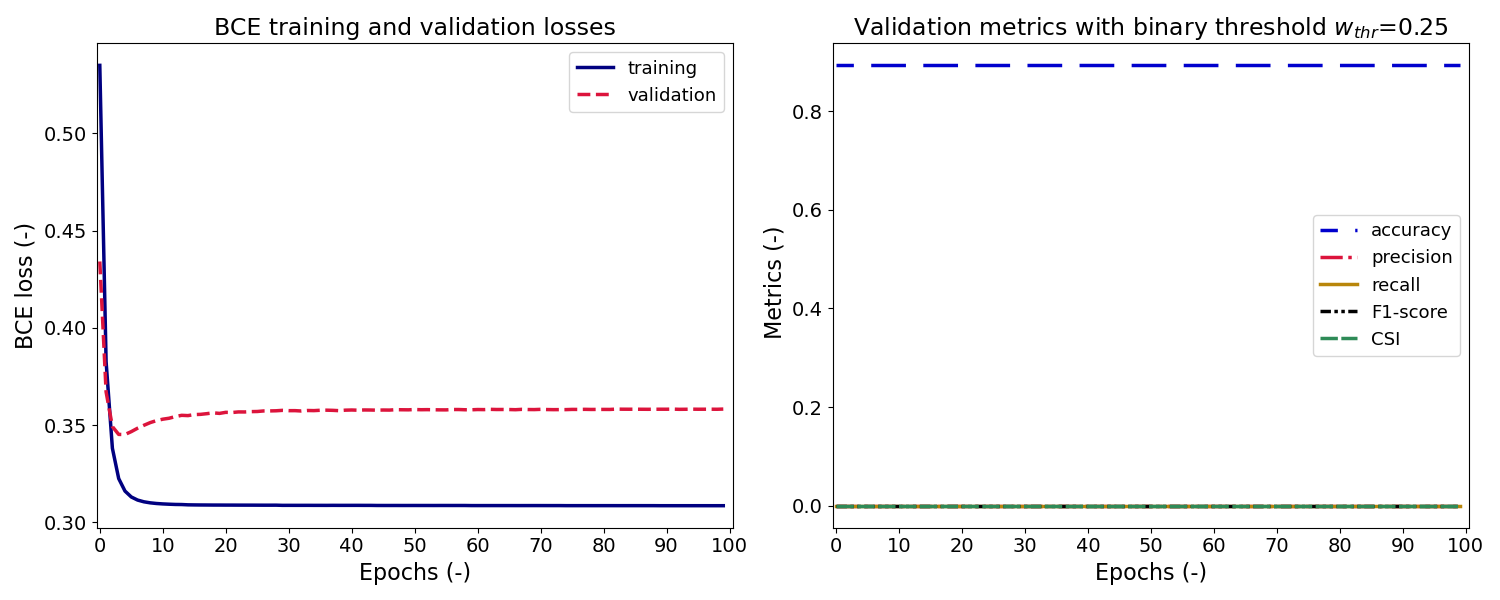

In [16]:
plot_losses_metrics(train_losses, val_losses, metrics, model_loss, loss_f=loss_f, water_threshold=0.25)

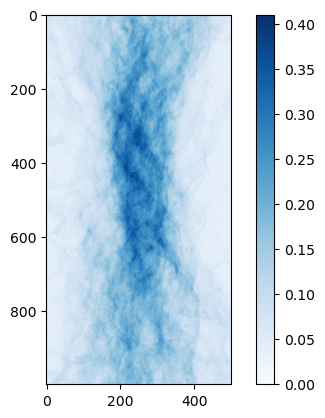

In [ ]:
# quick visualisation of the prediction on a test sample
# notice how the output is extremely noisy and not meaningful

pred_test = model_loss(test_set[1][0].unsqueeze(0).to(device)).squeeze(0).detach().cpu().numpy()

%matplotlib inline
plt.imshow(pred_test, vmin=0, cmap='Blues')
plt.colorbar()
plt.show()

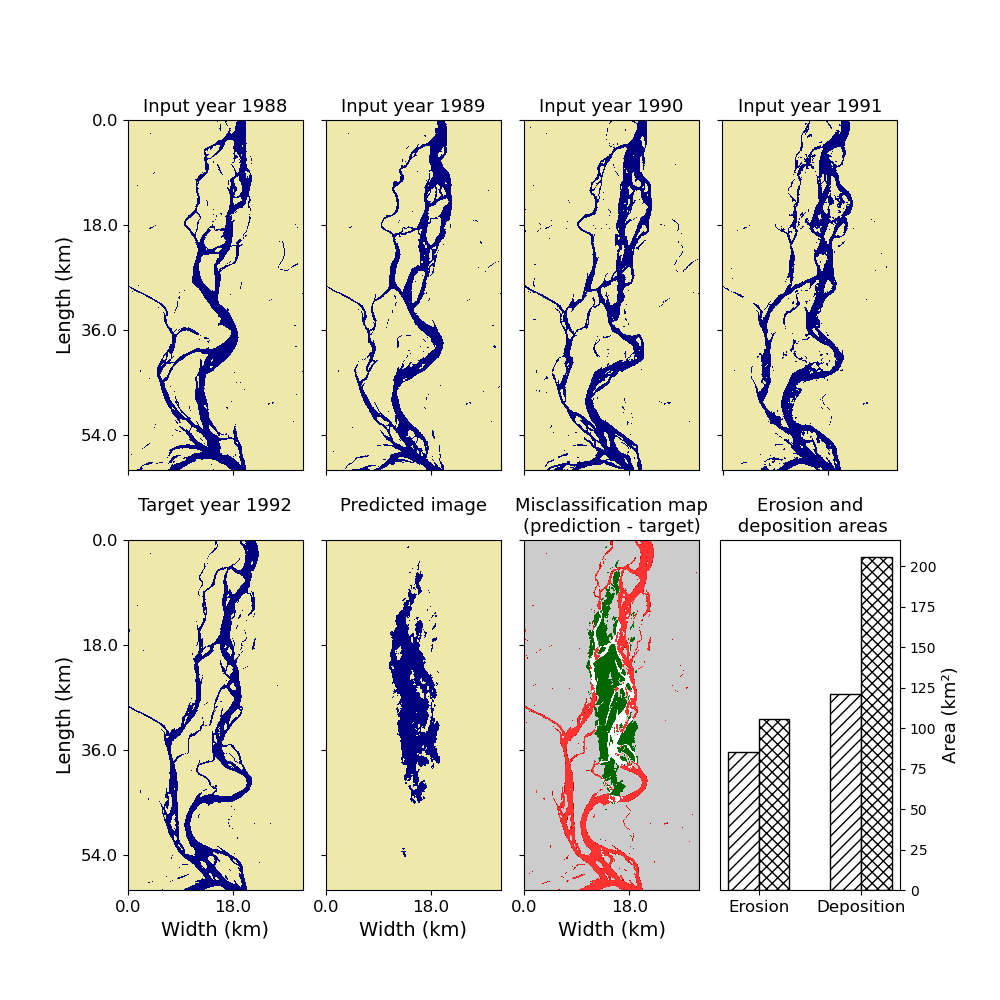

In [ ]:
# visualize evolution on a test sample 
# check different values of the threshold to see how the output changes

show_evolution_nolegend_nn(0, test_set, model_loss, device=device, water_threshold=0.25)

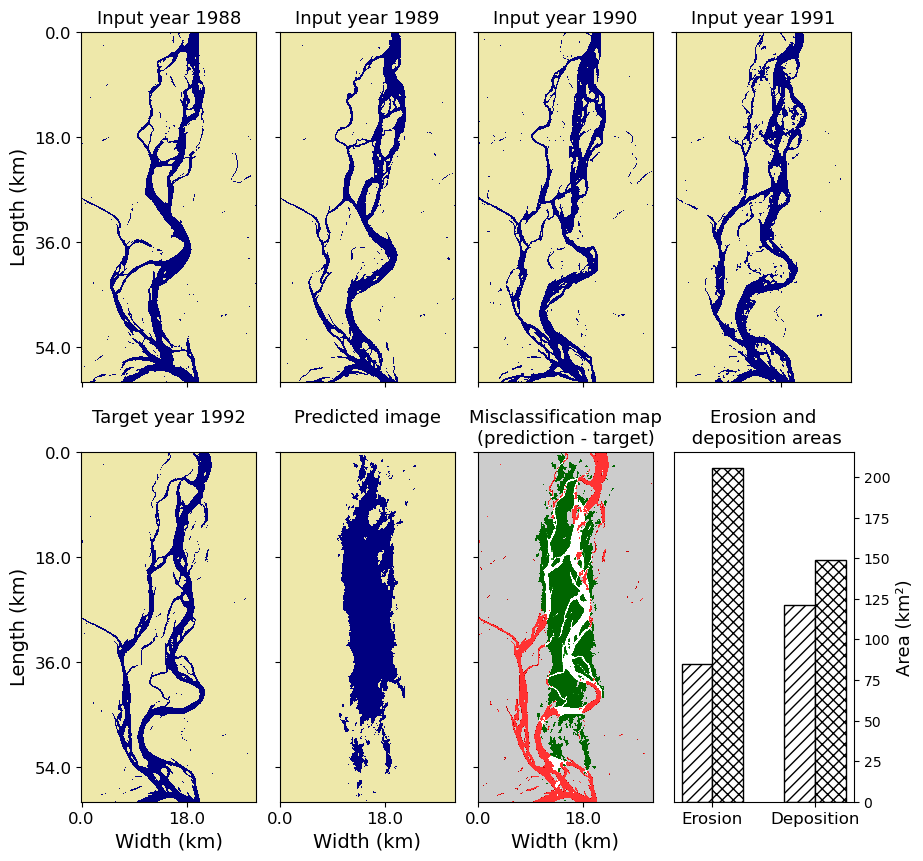

In [77]:
show_evolution_nolegend_nn(0, test_set, model_loss, device=device, water_threshold=0.2)

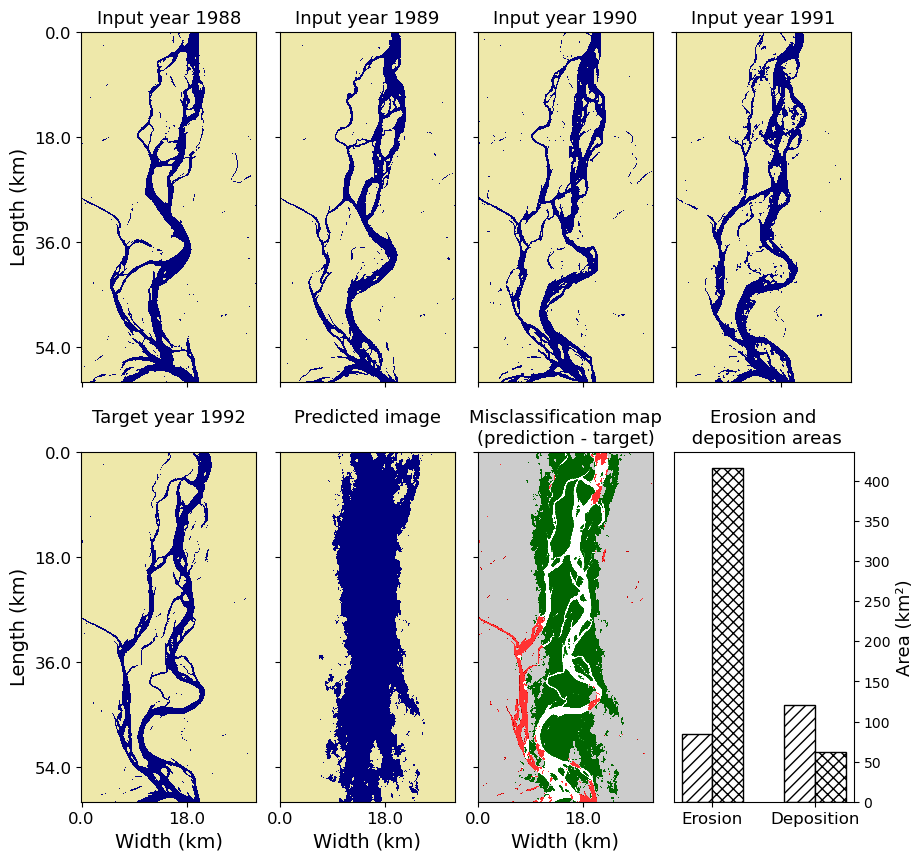

In [86]:
show_evolution_nolegend_nn(0, test_set, model_loss, device=device, water_threshold=0.15)